### model training


In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import lightgbm as lgb
import warnings

from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import classification_report, precision_recall_curve, average_precision_score, roc_auc_score , accuracy_score , precision_score, recall_score, f1_score, confusion_matrix

# Models
# from sklearn.linear_model import LogisticRegression
# from sklearn.ensemble import RandomForestClassifier , ExtraTreesClassifier, GradientBoostingClassifier, AdaBoostClassifier ,StackingClassifier
# from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
# from catboost import CatBoostClassifier
# from sklearn.neighbors import KNeighborsClassifier
# from sklearn.tree import DecisionTreeClassifier
# from sklearn.naive_bayes import GaussianNB
# from sklearn.svm import SVC


# Imbalanced-learn for handling class imbalance correctly in pipelines
from imblearn.pipeline import Pipeline as ImbPipeline

# Model Explainability
import shap

# Configure settings for cleaner output
%matplotlib inline
warnings.filterwarnings('ignore')
sns.set_style('whitegrid')


c:\Users\PC\BankMarketing\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df = pd.read_csv('../data/eda_data.csv' )
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [3]:
df.shape

(39404, 20)

In [4]:
# Mapping dictionary
mapping = {"yes": 1, "no": 0}

# Apply mapping 

df['y'] = df['y'].map(mapping)


In [5]:
X = df.drop(columns=['y'],axis=1)
y = df['y']
y.head()

0    0
1    0
2    0
3    0
4    0
Name: y, dtype: int64

#### train test split

In [6]:
# Stratified split ensures the proportion of the target class is the same across all sets
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.30, stratify=y, random_state=42
)
X_validate, X_test, y_validate, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, stratify=y_temp, random_state=42
)

print(f"Training set shape: {X_train.shape}")
print(f"Validation set shape: {X_validate.shape}")
print(f"Test set shape: {X_test.shape}")

Training set shape: (27582, 19)
Validation set shape: (5911, 19)
Test set shape: (5911, 19)


#### Data Preprocessing Pipeline Setup And models dictionary

In [7]:
# Identify column types 
num_cols = X_train.select_dtypes(include=['int64', 'float64']).columns
cat_cols = X_train.select_dtypes(include=['object', 'category']).columns

# Create the preprocessor to scale numeric features and one-hot encode categoricals
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore',sparse_output=False), cat_cols)
    ],
    remainder='passthrough'
)

# Define a dictionary of models to evaluate
models = {
    # "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    # "Random Forest": RandomForestClassifier(random_state=42),
    "LightGBM": LGBMClassifier(random_state=42),
    # "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
    # "CatBoost": CatBoostClassifier(verbose=False, random_state=42),
    # "K-Nearest Neighbors": KNeighborsClassifier(),
    # "Decision Tree": DecisionTreeClassifier(),
    # "Extra Trees": ExtraTreesClassifier(),
    # "Gradient Boosting": GradientBoostingClassifier(),
    # "AdaBoost": AdaBoostClassifier(),
    # "Naive Bayes": GaussianNB(),
    # "SVM": SVC(probability=True),

    # # stacking ensemble (LGBMClassifier + RandomForest + XGBoost)
    # "stacking_model":StackingClassifier(
    #     estimators=[
    #         ("rf", RandomForestClassifier(random_state=42)),
    #         ("xgb", XGBClassifier(
    #             use_label_encoder=False, eval_metric='logloss',
    #             random_state=42
    #         ))
    #     ],
    #     final_estimator=LGBMClassifier(random_state=42),
    #     cv=5,
    #     n_jobs=-1
    # )
    
}


#### Evaluation Function.

In [8]:
def evaluate_classification(y_true, y_pred, y_prob=None):
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, zero_division=0)
    rec = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)
    auc = roc_auc_score(y_true, y_prob) if y_prob is not None else None
    return acc, prec, rec, f1, auc


#### Cross Validation

#### Note : scale_pos_weight ratio not provided better results so code of it is commented out

In [9]:
results = []
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

from collections import Counter

# Calculate imbalance ratio
# class_counts = Counter(y_train)
# scale_pos_weight_ratio = class_counts[0] / class_counts[1]
# print(f"Calculated scale_pos_weight: {scale_pos_weight_ratio:.2f}")


print("--- Running Baseline Model Evaluation with Detailed Metrics ---")
for model_name, model in models.items():
    print(f"\nTraining {model_name} with Stratified K-Fold...")
    
    fold_metrics = []

    
    for fold, (train_idx, val_idx) in enumerate(skf.split(X_train, y_train)):
        # Split train/val
        X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

        #pipeline for each fold
        pipeline = ImbPipeline(steps=[
            ('preprocessor', preprocessor),
            ('feature_selection', SelectFromModel(
                lgb.LGBMClassifier(n_estimators=200,random_state=42),
                max_features=31,   # or median but it select different number of features for each fold , which make problems
                threshold=-np.inf  # ensure max_features is used
            )),
            # ('feature_selection', SelectFromModel(
            #     lgb.LGBMClassifier(
            #         n_estimators=200,
            #         random_state=42,
            #         scale_pos_weight=scale_pos_weight_ratio  # Apply weighting in feature selection too
            #     ),
            #     max_features=31,   
            #     threshold=-np.inf
            # )),
            ('classifier', model)
        ])
        
        # Fit and predict
        pipeline.fit(X_tr, y_tr)
        y_pred = pipeline.predict(X_val)
        y_proba = pipeline.predict_proba(X_val)[:, 1] if hasattr(pipeline, "predict_proba") else None
        
        # Metrics
        acc  = accuracy_score(y_val, y_pred)
        prec = precision_score(y_val, y_pred, zero_division=0)
        rec  = recall_score(y_val, y_pred, zero_division=0)
        f1   = f1_score(y_val, y_pred, zero_division=0)
        auc  = roc_auc_score(y_val, y_proba) if y_proba is not None else 0
        
        fold_metrics.append((acc, prec, rec, f1, auc))
        print(f"  Fold {fold+1} | Acc: {acc:.4f} | Prec: {prec:.4f} | Rec: {rec:.4f} | F1: {f1:.4f} | AUC: {auc:.4f}")

    # Average across folds
    avg_acc, avg_prec, avg_rec, avg_f1, avg_auc = np.mean(fold_metrics, axis=0)
    results.append({
        "Model": model_name,
        "CV_Accuracy": avg_acc,
        "CV_Precision": avg_prec,
        "CV_Recall": avg_rec,
        "CV_F1": avg_f1,
        "CV_ROC_AUC": avg_auc
    })
    
    print(f" {model_name} | CV F1: {avg_f1:.4f} | CV ROC-AUC: {avg_auc:.4f}")

# Final comparison
results_df = pd.DataFrame(results).sort_values(by="CV_ROC_AUC", ascending=False)
print("\n🔹 Final Model Comparison (sorted by CV ROC-AUC):")
print(results_df)

best_model_name = results_df.iloc[0]["Model"]
print(f"\n Best baseline model type: {best_model_name}")


--- Running Baseline Model Evaluation with Detailed Metrics ---

Training LightGBM with Stratified K-Fold...
[LightGBM] [Info] Number of positive: 2575, number of negative: 19490
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003808 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 436
[LightGBM] [Info] Number of data points in the train set: 22065, number of used features: 60
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116701 -> initscore=-2.024052
[LightGBM] [Info] Start training from score -2.024052
[LightGBM] [Info] Number of positive: 2575, number of negative: 19490
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002906 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 378
[Light

In [10]:
print(f"\n--- Hyperparameter Tuning for {best_model_name} ---")

# from collections import Counter
# class_counts = Counter(y_train)
# scale_pos_weight_ratio = class_counts[0] / class_counts[1]  # negative / positive
# print(f"Calculated scale_pos_weight ratio: {scale_pos_weight_ratio:.2f}")


tuning_pipeline = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('feature_selection', SelectFromModel(
        lgb.LGBMClassifier(n_estimators=200,random_state=42),
        max_features=31,   # or median but it select different number of features for each fold , which make problems
        threshold=-np.inf  # ensure max_features is used
    )),
    ('classifier', models[best_model_name])
])

# Define a parameter grid for hyperparameter tuning 
param_grid = {
    'classifier__n_estimators': [500, 1000, 1500],   
    'classifier__learning_rate': [0.01, 0.05, 0.1], 
    'classifier__max_depth': [-1, 6, 10],           
    'classifier__num_leaves': [31, 63, 127],        
    'classifier__min_child_samples': [10, 20, 50],  
    'classifier__subsample': [0.7, 0.8, 1.0],       
    'classifier__colsample_bytree': [0.7, 0.8, 1.0],
    'classifier__reg_alpha': [0, 0.1, 1],           
    'classifier__reg_lambda': [0, 0.1, 1] ,
    # 'classifier__scale_pos_weight': [
    #     round(scale_pos_weight_ratio * 0.5, 2),  # lower
    #     round(scale_pos_weight_ratio, 2),        # exact
    #     round(scale_pos_weight_ratio * 1.5, 2)   # higher
    # ]          
}


# Set up the randomized search
random_search = RandomizedSearchCV(
    tuning_pipeline,
    param_distributions=param_grid,
    n_iter=10,  
    cv=skf,
    scoring='roc_auc',
    n_jobs=-1,
    random_state=42
)

# Fit on the training data to find the best model
random_search.fit(X_train, y_train)

# The final, tuned model is the best estimator found by the search
final_model_pipeline = random_search.best_estimator_
print(f"\n Best parameters found: {random_search.best_params_}")


--- Hyperparameter Tuning for LightGBM ---
[LightGBM] [Info] Number of positive: 3219, number of negative: 24363
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002095 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 440
[LightGBM] [Info] Number of data points in the train set: 27582, number of used features: 60
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116707 -> initscore=-2.023995
[LightGBM] [Info] Start training from score -2.023995
[LightGBM] [Info] Number of positive: 3219, number of negative: 24363
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001394 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 382
[LightGBM] [Info] Number of data points in the train set: 27582, number

#### top 10 feature importance

In [11]:
# Get transformed feature names after preprocessor
all_features = final_model_pipeline.named_steps['preprocessor'].get_feature_names_out()

if 'feature_selection' in final_model_pipeline.named_steps:
    selector = final_model_pipeline.named_steps['feature_selection']
    selected_mask = selector.get_support()
    feature_names = all_features[selected_mask]
else:
    feature_names = all_features

importances = final_model_pipeline.named_steps['classifier'].feature_importances_
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

print("\n--- Top 10 Most Important Features ---")
print(importance_df.head(10))



--- Top 10 Most Important Features ---
                  Feature  Importance
0                num__age        5551
7          num__euribor3m        5243
1           num__campaign        2434
6      num__cons.conf.idx        1503
5     num__cons.price.idx        1467
2              num__pdays         797
3           num__previous         776
4       num__emp.var.rate         644
30  cat__poutcome_failure         584
21        cat__housing_no         577


## IMPORTANT
##### Final Model Evaluation and Decision Threshold Optimization using custom business metric and precision recall curves (imbalance dataset).



--- Finding Optimal Threshold on Validation Set ---
 Best Threshold for Max Profit: 0.1698
 Best Threshold: 0.16980619206935235
Recall = 0.629, Precision = 0.454
Calls Made = 957, True Positives = 434
Max Profit = $10839.00


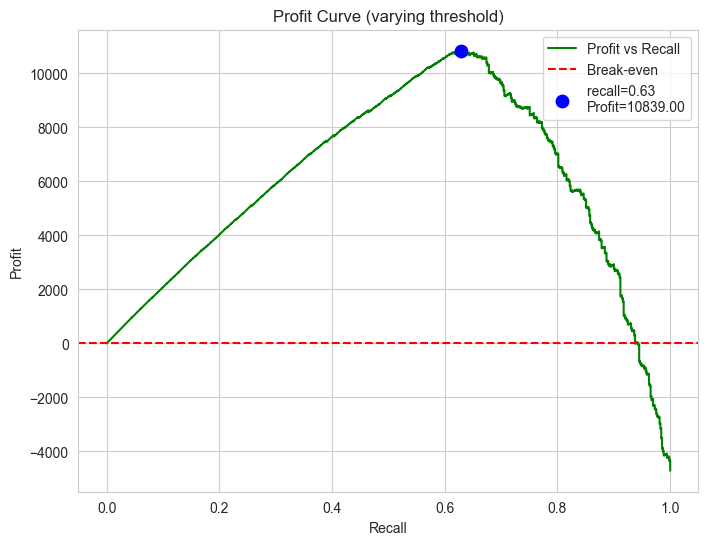

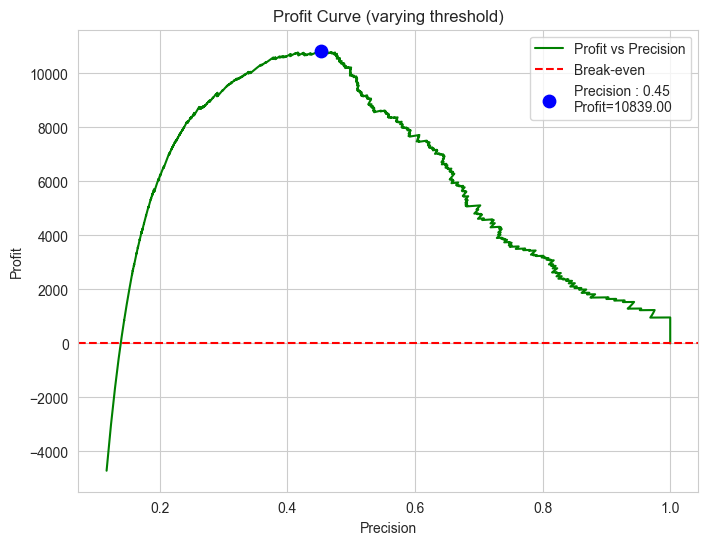

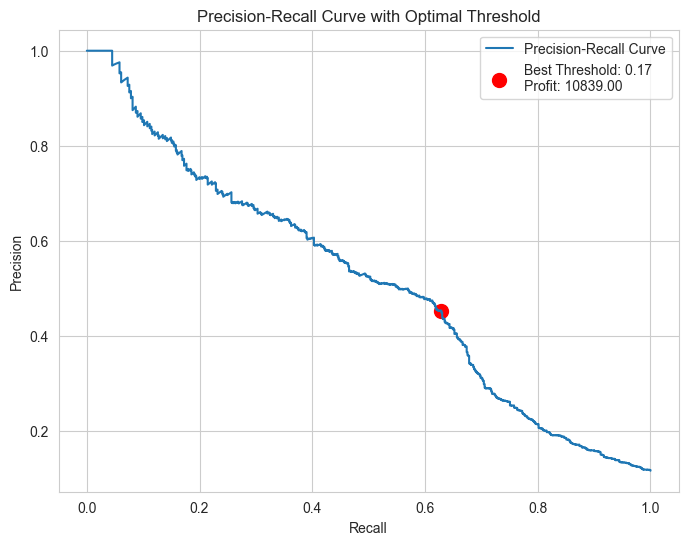

In [ ]:
print("\n--- Finding Optimal Threshold on Validation Set ---")

# Get prediction probabilities on the validation data
y_val_proba = final_model_pipeline.predict_proba(X_validate)[:, 1]

# Define business metrics

# marketing_cost per call
# Affected by TP and FP --> we make call to both , 1.actual true and predicted true , 2. actual false but predicted true)
call_cost = 5.0  # (including labor & infrastructure)

# this cost are affect after customer Acquisition (agree for subscription)(only Affected by TP-actual true and predicted true )
# Onboarding & KYC verification cost
onboarding_cost = 5
#Account management costs(back-office ops, compliance)
acc_cost = 15
# Other overheads(like customer support): 
other_overheads = 10
total_customer_cost = onboarding_cost + acc_cost + other_overheads  # Total acquisition cost

# calculating revenue per costomer (only Affected by TP-actual true and predicted true )
# Average deposit amount = 4000
# Interest spread(Interest Earned by Bank on Loans or Investments − Interest Paid to Customer on Deposit) = 2.2% annually
# Customer holds deposit for 1 year
subscription_revenue = 88 # (4000 * 0.022)

# Calculate profit for every possible threshold 
precisions, recalls, thresholds = precision_recall_curve(y_validate, y_val_proba)

# To avoid division by zero
valid_precisions = np.maximum(precisions, 1e-8)
calls_made = (recalls * sum(y_validate)) / valid_precisions
#total profit = total_revenue - total_cost(cost of handling + marketing)
profit = (recalls * sum(y_validate) * subscription_revenue) - (recalls * sum(y_validate) * total_customer_cost) - (calls_made * call_cost)


# Find the threshold that corresponds to the maximum profit
best_threshold = thresholds[np.argmax(profit)]
print(f" Best Threshold for Max Profit: {best_threshold:.4f}")


# True positives and predicted positives at each point
total_pos = sum(y_validate)
TP = recalls * total_pos
pred_pos = np.divide(TP, np.maximum(precisions, 1e-8))  # calls made

# === Find Best Point ===
best_idx = np.argmax(profit)
print(f" Best Threshold: {best_threshold}")
print(f"Recall = {recalls[best_idx]:.3f}, Precision = {precisions[best_idx]:.3f}")
print(f"Calls Made = {int(pred_pos[best_idx])}, True Positives = {int(TP[best_idx])}")
print(f"Max Profit = ${profit[best_idx]:.2f}")

# Find index of max profit for point of curves
max_idx = np.argmax(profit)
max_recall = recalls[max_idx]
max_precision = precisions[max_idx]
max_profit = profit[max_idx]

# === Profit Curve ===
plt.figure(figsize=(8,6))
plt.plot(recalls, profit, label="Profit vs Recall", color="green")
plt.axhline(0, color="red", linestyle="--", label="Break-even")
plt.scatter(max_recall, max_profit, color="blue", s=80, zorder=5, 
            label=f"recall={max_recall:.2f} \nProfit={max_profit:.2f}")
plt.xlabel("Recall")
plt.ylabel("Profit")
plt.title("Profit Curve (varying threshold)")
plt.grid(True)
plt.legend()
plt.show()


# Plot
plt.figure(figsize=(8,6))
plt.plot(precisions, profit, label="Profit vs Precision", color="green")
plt.axhline(0, color="red", linestyle="--", label="Break-even")
plt.scatter(max_precision, max_profit, color="blue", s=80, zorder=5, 
            label=f"Precision : {max_precision:.2f} \nProfit={max_profit:.2f}")
plt.xlabel("Precision")
plt.ylabel("Profit")
plt.title("Profit Curve (varying threshold)")
plt.grid(True)
plt.legend()
plt.show()


plt.figure(figsize=(8, 6))
plt.plot(recalls, precisions, label="Precision-Recall Curve")
plt.scatter(recalls[best_idx], precisions[best_idx], color='red', s=100,
            label=f"Best Threshold: {best_threshold:.2f}\nProfit: {max_profit:.2f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve with Optimal Threshold")
plt.legend()
plt.grid(True)
plt.show()


In [13]:
# Make predictions on the TEST set
y_test_proba = final_model_pipeline.predict_proba(X_test)[:, 1]

# Apply the threshold found on the validation set to get final class predictions
y_test_pred_optimized = (y_test_proba >= best_threshold).astype(int)

print(f"\n---  Final Report on Test Set (Threshold = {best_threshold:.4f}) ---")
print(classification_report(y_test, y_test_pred_optimized, target_names=['No Subscription', 'Subscription']))




---  Final Report on Test Set (Threshold = 0.4512) ---
                 precision    recall  f1-score   support

No Subscription       0.91      0.98      0.94      5222
   Subscription       0.62      0.31      0.41       689

       accuracy                           0.90      5911
      macro avg       0.77      0.64      0.68      5911
   weighted avg       0.88      0.90      0.88      5911



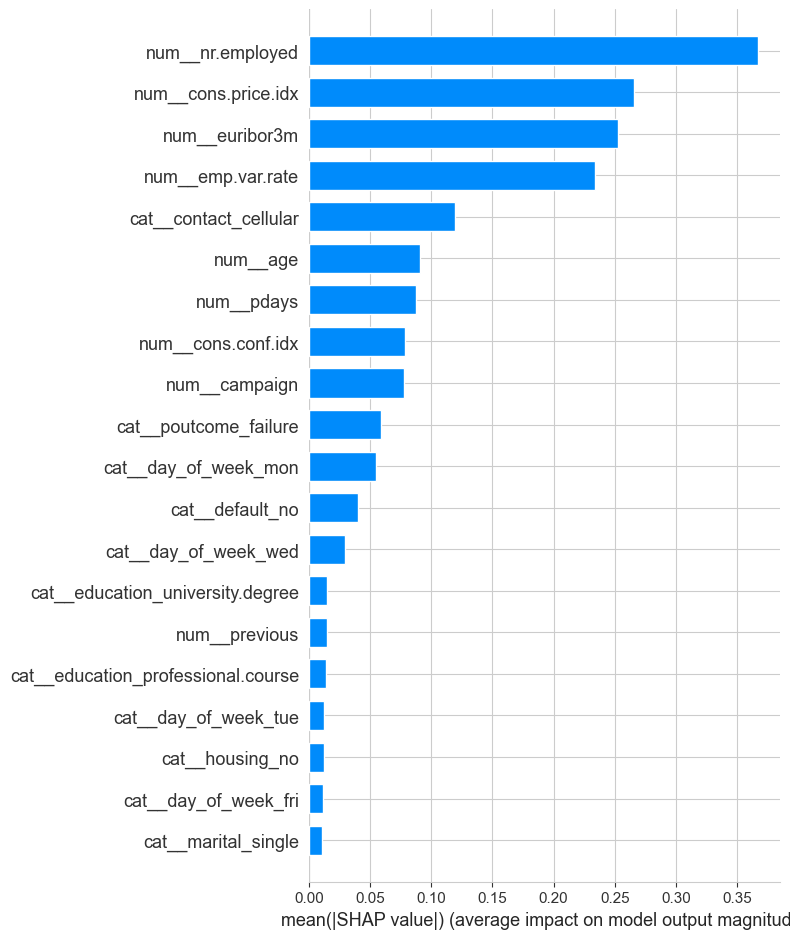

In [14]:
# Full preprocessing
X_test_preprocessed = final_model_pipeline.named_steps['preprocessor'].transform(X_test)

# Apply feature selection
selector = final_model_pipeline.named_steps['feature_selection']
X_test_processed = selector.transform(X_test_preprocessed)

# Correct feature names
all_features = final_model_pipeline.named_steps['preprocessor'].get_feature_names_out()
feature_names = all_features[selector.get_support()]

X_test_processed_df = pd.DataFrame(X_test_processed, columns=feature_names)

explainer = shap.TreeExplainer(final_model_pipeline.named_steps['classifier'])
shap_values = explainer.shap_values(X_test_processed_df)

shap.summary_plot(shap_values, X_test_processed_df, plot_type="bar")
